In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
z_size = 100
img_len = 64
channels = 3
batch_size = 64
num_epochs = 500
lr = 0.0002
beta1 = 0.5

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize((img_len, img_len)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.Flowers102(root="./data", download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Generator
class Generator(nn.Module):
    def __init__(self, z_size):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_size, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)

# Initialize models and optimizers
netG = Generator(z_size).to(device)
netD = Discriminator().to(device)

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Train Discriminator
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,1), 1, dtype=torch.float, device=device)

        output = netD(real_cpu)
        errD_real = F.binary_cross_entropy(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, z_size, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)
        output = netD(fake.detach())
        errD_fake = F.binary_cross_entropy(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake)
        errG = F.binary_cross_entropy(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')

    # Save a generated image every epoch
    with torch.no_grad():
        fake = netG(torch.randn(1, z_size, 1, 1, device=device)).detach().cpu()
        img = torchvision.utils.make_grid(fake, normalize=True)
        torchvision.utils.save_image(img, 'generated_image.png')

print("Training finished")

[0/500][0/16] Loss_D: 1.5021 Loss_G: 3.6233 D(x): 0.5561 D(G(z)): 0.5844/0.0281
[1/500][0/16] Loss_D: 0.3264 Loss_G: 12.0913 D(x): 0.7790 D(G(z)): 0.0002/0.0000
[2/500][0/16] Loss_D: 0.2297 Loss_G: 7.4238 D(x): 0.8497 D(G(z)): 0.0328/0.0007
[3/500][0/16] Loss_D: 0.1249 Loss_G: 13.2540 D(x): 0.8942 D(G(z)): 0.0000/0.0000
[4/500][0/16] Loss_D: 0.1589 Loss_G: 5.9042 D(x): 0.9759 D(G(z)): 0.1217/0.0030
[5/500][0/16] Loss_D: 0.2136 Loss_G: 6.0194 D(x): 0.9565 D(G(z)): 0.1243/0.0026
[6/500][0/16] Loss_D: 0.1593 Loss_G: 5.7971 D(x): 0.9417 D(G(z)): 0.0890/0.0032
[7/500][0/16] Loss_D: 0.3578 Loss_G: 8.5952 D(x): 0.9085 D(G(z)): 0.2145/0.0002
[8/500][0/16] Loss_D: 0.4542 Loss_G: 4.9924 D(x): 0.8507 D(G(z)): 0.2054/0.0115
[9/500][0/16] Loss_D: 1.3808 Loss_G: 1.8709 D(x): 0.3826 D(G(z)): 0.0220/0.1951
[10/500][0/16] Loss_D: 0.9581 Loss_G: 4.9998 D(x): 0.8664 D(G(z)): 0.5086/0.0113
[11/500][0/16] Loss_D: 0.2689 Loss_G: 3.5281 D(x): 0.8255 D(G(z)): 0.0592/0.0370
[12/500][0/16] Loss_D: 0.6664 Loss_G

In [2]:
import matplotlib.pyplot as plt

In [5]:
torch.save(netG.state_dict(), "models/generator.pth")

In [6]:
netG.load_state_dict(torch.load("models/generator.pth"))

/tmp/ipykernel_167864/1658640826.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load("models/generator.pth"))


<All keys matched successfully>

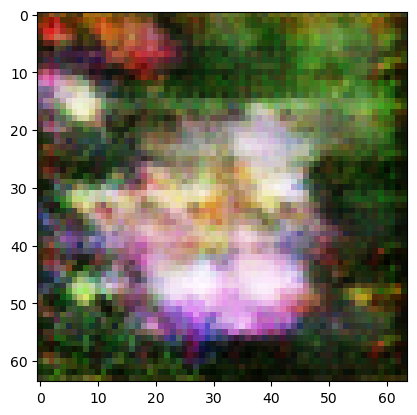

In [11]:

fake = netG(torch.randn(1, z_size, 1, 1, device=device)).detach().cpu()
img = torchvision.utils.make_grid(fake, normalize=True)
plt.imshow(img.T)